In [1]:
import os
os.chdir("..")
os.chdir("src")
from evaluate_lda import get_files, coherence_score, word_cloud
from utils.utils import get_json
os.chdir("..")

### Vamos usar o topn=7, pois é aonde temos a maior queda no score de coherence c_v

### Get model outputs

In [2]:
lda_model, vec, corpus, id2word = get_files("models/lda/best_model_topn_7/pkl")
model_params_json = "src/lda_opt_outputs/results_stemmer_topn_7.json"
params = get_json(model_params_json)

topn = params["topn"]
n_topics = params["params"]["num_topics"]
model_params = params["params"]

In [3]:
print(f"topn = {topn}")
print()
print(f"n_topics = {n_topics}")
print()
print(f"model params = {model_params}")


topn = 7

n_topics = 6

model params = {'n_filter': 300, 'num_topics': 6, 'chunksize': 130, 'passes': 19, 'alpha': 0.93, 'eta': 0.61, 'decay': 0.8}


## Coherence Score

In [5]:
coherence_score(lda_model, vec, id2word, "c_npmi", topn)

0.1818720885728914

In [6]:
coherence_score(lda_model, vec, id2word, "c_v", topn)

0.6985488812896777

## Word Cloud

In [32]:
stop_words = []

with open("src/utils/stop_words.txt", "r") as file:
    for row in file:
        stop_words.append(row.strip())

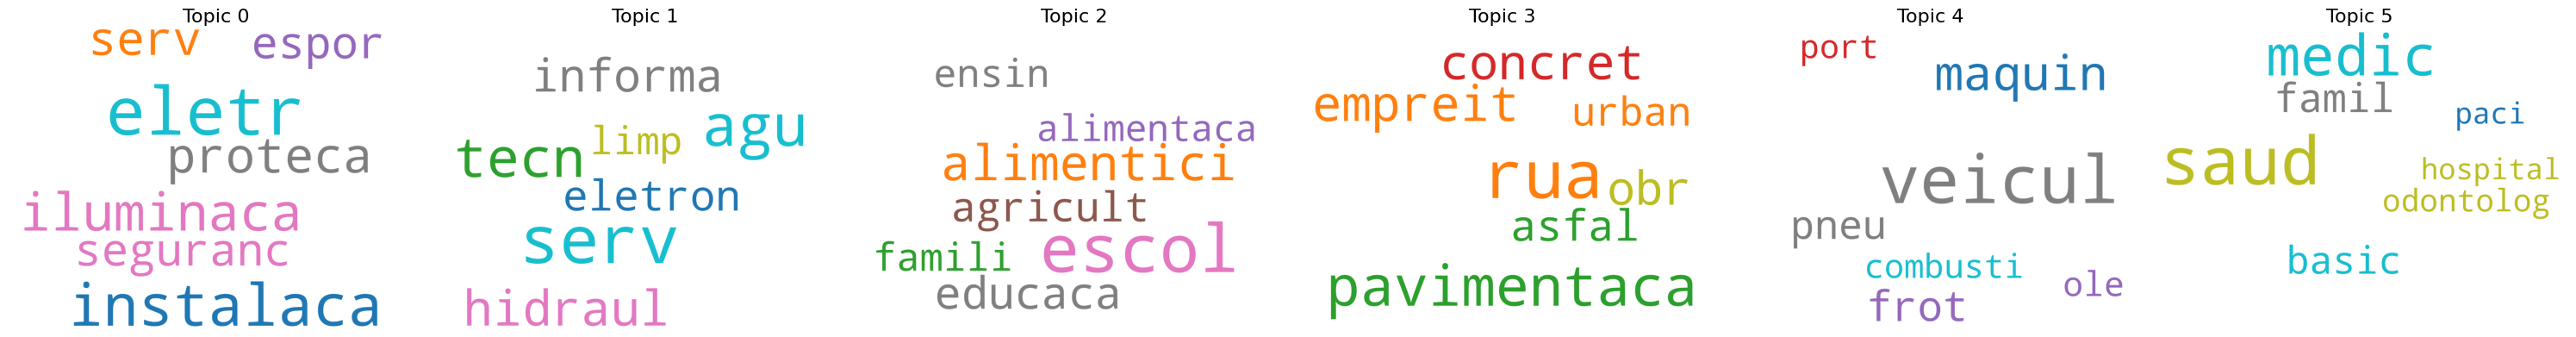

In [33]:
word_cloud(stopwords=stop_words, model=lda_model, n_topics=n_topics, max_words=topn)